In [ ]:
from maxarseg.geo_datasets import geoDatasets


dataset = geoDatasets.MxrSingleTileNoEmpty(str(tile_path))
sampler = samplers.BatchGridGeoSampler(dataset,
                                    batch_size=seg_config.batch_size,
                                    size=seg_config.size,
                                    stride=seg_config.stride)
dataloader = DataLoader(dataset , batch_sampler=sampler, collate_fn=stack_samples)

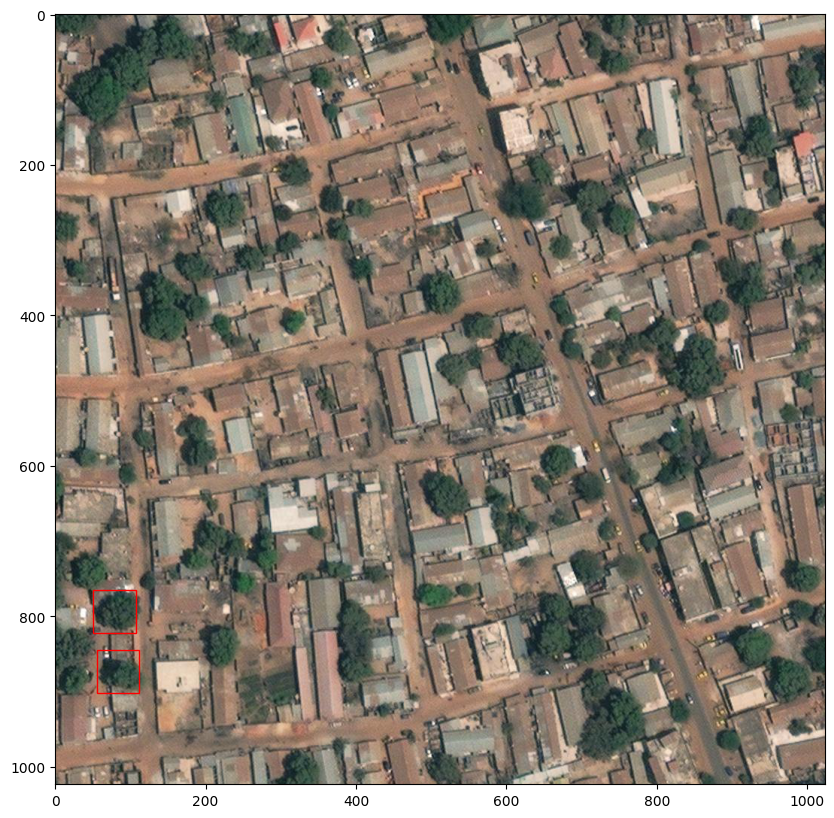

tensor([[ 50, 765, 107, 822],
        [ 55, 845, 112, 902]])

In [31]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import torch


file_path = '/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif'
window = Window(col_off=10000, row_off=500, width=1024, height=1024)

with rasterio.open(file_path) as src:
    data = src.read(window=window)

# Plot the image
plt.figure(figsize=(10, 10))
data = data.transpose((1, 2, 0))  # Change data shape from (3, 1024, 1024) to (1024, 1024, 3) for matplotlib
plt.imshow(data)


# Create a Rectangle patch
rect1 = patches.Rectangle((50,765),57,57,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((55,845),57,57,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)

plt.show()

boxes = torch.tensor([[50, 765, 50+57, 765+57],
                      [55,845 , 55+57, 845+57]])

boxes


In [37]:
from efficientvit.sam_model_zoo import create_sam_model
from efficientvit.models.efficientvit.sam import EfficientViTSamPredictor

wteSAM = create_sam_model(name="xl1", weight_url="models/evit/weights/sam/xl1.pt")
evit_sam_predictor = EfficientViTSamPredictor(wteSAM)

evit_sam_predictor.set_image(data, image_format = 'RGB')
#evit_sam_predictor.predict_torch(boxes = boxes, multimask_output= True, return_logits = True)


In [49]:
masks, quality, low_res_logits = evit_sam_predictor.predict_torch(boxes = boxes, multimask_output= True, return_logits = True)

In [50]:
masks = masks[torch.arange(masks.shape[0]), torch.argmax(quality, dim=1)]

In [43]:
import numpy as np

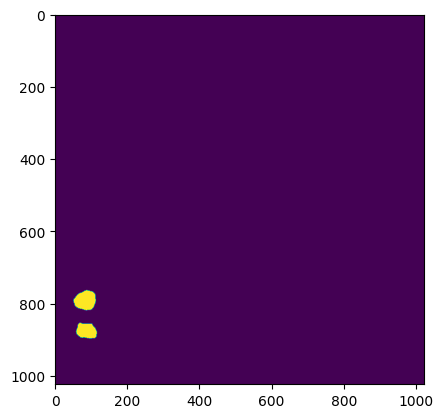

In [58]:
plt.imshow(np.greater(torch.max(masks, dim = 0).values, 0))

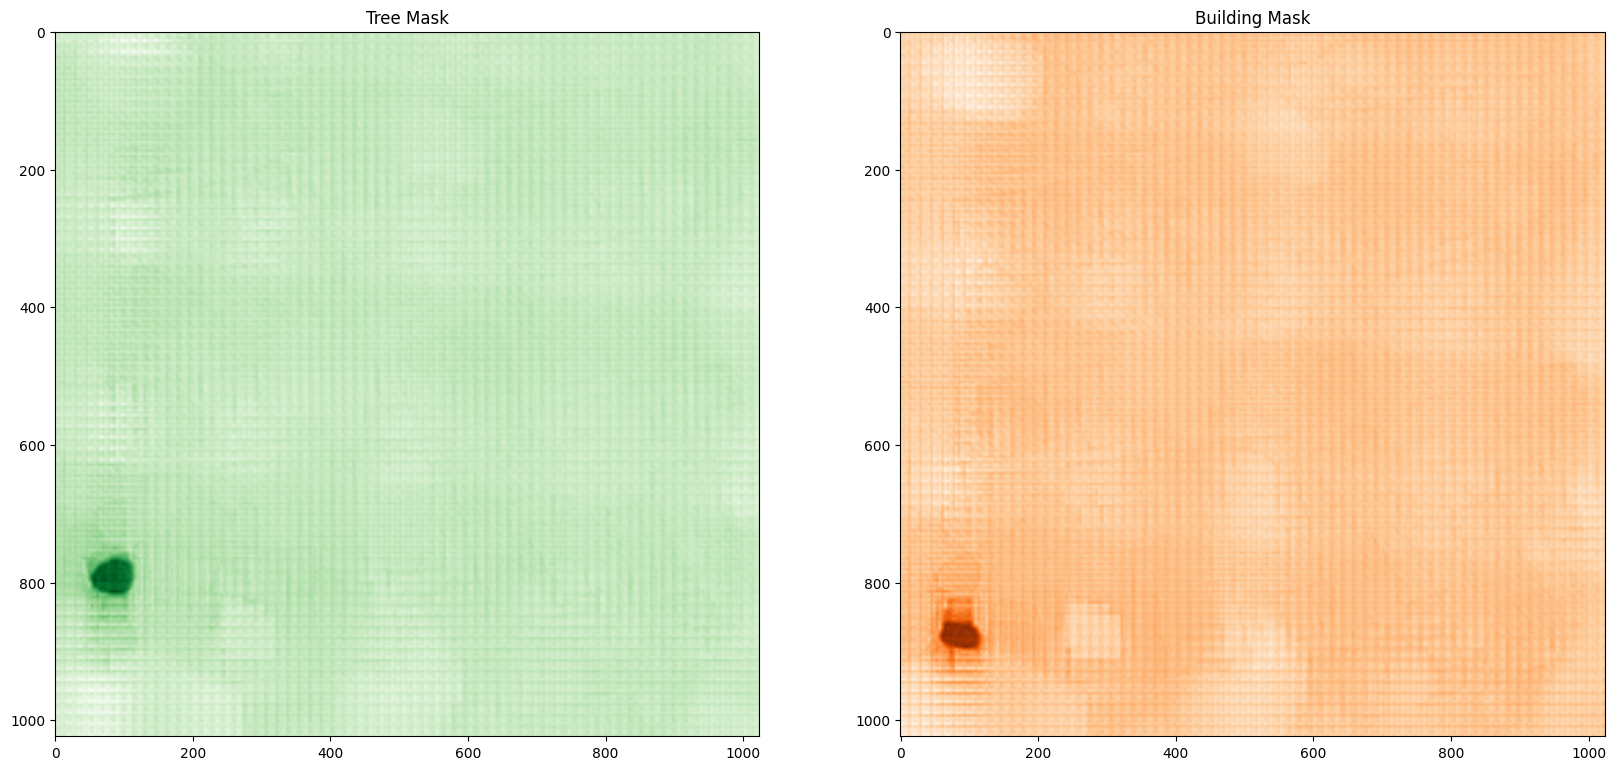

In [40]:
# Plot the masks
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot tree mask
ax[0].imshow(masks[0], cmap='Greens')
ax[0].set_title('Tree Mask')

# Plot building mask
ax[1].imshow(masks[1], cmap='Oranges')
ax[1].set_title('Building Mask')

plt.show()


In [3]:
from maxarseg.assemble import names
from maxarseg.assemble import holders

import os

# Change directory to the main folder
os.chdir("/nfs/home/vaschetti/maxarSrc/")


In [6]:
import yaml

# Load the YAML configuration file
with open('yaml_config/config_evit.yaml', 'r') as file:
    config = yaml.safe_load(file)

for key, value in config.items():
    print(f"{key}: {value}, {type(value)}")


event_ix: 2, <class 'int'>
when: pre, <class 'str'>
device_det: cuda:0, <class 'str'>
size_det: 600, <class 'int'>
stride_det: 400, <class 'int'>
GD_bs: 1, <class 'int'>
GD_root: ./models/GDINO, <class 'str'>
GD_config_file: configs/GroundingDINO_SwinT_OGC.py, <class 'str'>
GD_weights: weights/groundingdino_swint_ogc.pth, <class 'str'>
text_prompt: green tree, <class 'str'>
box_threshold: 0.15, <class 'float'>
text_threshold: 0.3, <class 'float'>
DF_bs: 32, <class 'int'>
max_area_GD_boxes_mt2: 6000, <class 'int'>
min_ratio_GD_boxes_edges: 0.0, <class 'float'>
perc_reduce_tree_boxes: 0.0, <class 'float'>
use_evit: False, <class 'bool'>
bs_seg: 2, <class 'int'>
device_seg: cuda:0, <class 'str'>
size_seg: 600, <class 'int'>
stride_seg: 400, <class 'int'>
ext_mt_build_box: 0, <class 'int'>
road_width_mt: 5, <class 'int'>
ESAM_root: ./models/EfficientSAM, <class 'str'>
ESAM_num_parall_queries: 5, <class 'int'>
out_dir_root: ./output/tiff, <class 'str'>


In [2]:
events_names = names.get_all_events()

event = holders.Event(events_names[2],
                        seg_config = None,
                        det_config = None,
                        when='pre')

Creating event: Gambia-flooding-8-11-2022
Region: AfricaWest-Full
Mosaics: ['105001002BD68F00', '10300100CFC9A500', '1040010073D77D00']


In [3]:
all_mosaics_names = event.all_mosaics_names

In [4]:
m0 = event.mosaics[all_mosaics_names[1]]

In [7]:
m0.tiles_paths[2]

PosixPath('/nfs/projects/overwatch/maxar-segmentation/maxar-open-data/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031233.tif')

In [8]:
import torch

boxes = torch.arange(44)
num_trees = 13
num_par_queries = 12
ix_last_tree = num_trees - 1
for i in range(0, boxes.shape[0], num_par_queries):
    print(i) #TODO: gli alberi vanno sottratti di 1
    print(boxes[i:i+num_par_queries])
    print('Alberi nel batch', num_trees - i)
    print(i, '<', ix_last_tree, '<', (i + num_par_queries - 1))
    if i < ix_last_tree < (i + num_par_queries):
        print('nel batch alberi e case\n')
    elif i < ix_last_tree: #solo alberi
        print('nel batch solo alberi\n')
    elif i > ix_last_tree: #solo build
        print('nel batch solo build\n')


#Vedere questo caso

0
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Alberi nel batch 13
0 < 12 < 11
nel batch solo alberi

12
tensor([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
Alberi nel batch 1
12 < 12 < 23
24
tensor([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
Alberi nel batch -11
24 < 12 < 35
nel batch solo build

36
tensor([36, 37, 38, 39, 40, 41, 42, 43])
Alberi nel batch -23
36 < 12 < 47
nel batch solo build



In [12]:
import torch

boxes = torch.arange(44)
num_trees = 13
num_par_queries = 12
ix_last_tree = num_trees - 1
for i in range(0, boxes.shape[0], num_par_queries):
    print(boxes[i:i+num_par_queries])
    if num_trees - i > num_par_queries and num_trees - i > 0: #solo trees
        print('There are', num_trees - i, 'trees and no build\n')
    elif num_trees - i < num_par_queries and num_trees - i > 0: #trees and build
        print('There are', num_trees - i, 'trees left in the batch\n')
    elif num_trees - i <= 0: #solo build
        print('There are only build. num trees:', num_trees - i, '\n')


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
There are 13 trees and no build

tensor([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
There are 1 trees left in the batch

tensor([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])
There are only build. num trees: -11 

tensor([36, 37, 38, 39, 40, 41, 42, 43])
There are only build. num trees: -23 



In [62]:
a = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
b = torch.tensor([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                 [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]])
b[0] = b[0] + 2
b[1] = b[1] - 2
b = torch.max(b, dim = 0).values
torch.max(a,b )



tensor([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22])

In [71]:
tree_build_mask = torch.full((2, 100, 100), float('-inf'), dtype = torch.float32)
tree_build_mask[0].shape

torch.Size([100, 100])

In [87]:
masks = torch.full((21, 3, 100, 100), 12, dtype = torch.float32)
trees_in_mixed_batch = 21
quality = torch.full((21, 3), 12, dtype = torch.float32)
masks = masks[torch.arange(masks.shape[0]), torch.argmax(quality, dim=1)]
tree_build_mask[0] = torch.max(tree_build_mask[0], torch.max(masks[:trees_in_mixed_batch], dim=0).values)
tree_build_mask[1] = torch.max(tree_build_mask[1], torch.max(masks[trees_in_mixed_batch:], dim=0).values)

IndexError: max(): Expected reduction dim 0 to have non-zero size.

In [82]:
tree_build_mask.shape

torch.Size([2, 100, 100])

In [60]:
a = torch.tensor([[1,2,3]])
b = torch.tensor([[4,2,4],[7,1,4]])
torch.max(a,b).max(dim=0).values


tensor([7, 2, 4])

In [92]:
num_batch_tree_only

1

In [111]:
boxes = torch.arange(44)
num_trees = 40
num_par_queries = 40
num_batch_tree_only = num_trees // num_par_queries
trees_in_mixed_batch = round(num_par_queries * (num_trees/num_par_queries -  num_trees // num_par_queries))
for y, i in enumerate(range(0, boxes.shape[0], num_par_queries)):
    print(boxes[i:i+num_par_queries])
    if y < num_batch_tree_only or boxes[i:i+num_par_queries].shape[0] == trees_in_mixed_batch:
        print('only trees\n')
        
    elif y > num_batch_tree_only or trees_in_mixed_batch == 0:
        print('only build\n')
    else:# y == num_batch_tree_only:# and trees_in_mixed_batch != 0:# and boxes[i:i+num_par_queries].shape[0] != trees_in_mixed_batch:
        print('mixed batch, with: ', trees_in_mixed_batch, 'trees and build\n')
        
#13//3, 13/3, round(3 * (13/3 - 13 //3))
 



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39])
only trees

tensor([40, 41, 42, 43])
only build



In [38]:
import torch

boxes = torch.arange(44)
num_trees = 17
num_par_queries = 20
for i in range(0, boxes.shape[0], num_par_queries):
    print(boxes[i:i+num_par_queries])
    if i < num_trees < (i+ num_par_queries):
        #print(i, '<', num_trees, '<', (i+ num_par_queries))
        print('mixed batch, with: ', num_trees - num_par_queries, 'trees and build\n')
    elif i <= num_trees: #solo alberi
        #print((i * num_par_queries), '<', num_trees, '<', ((i+1) * num_par_queries))
        print('only trees\n')
    elif i > num_trees: #solo build
        #print((i * num_par_queries), '<', num_trees, '<', ((i+1) * num_par_queries))
        print('only build\n')

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])
mixed batch, with:  -3 trees and build

tensor([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39])
only build

tensor([40, 41, 42, 43])
only build



In [9]:
sparse_tensor

tensor(indices=tensor([[0, 1, 1],
                       [2, 0, 2]]),
       values=tensor([3., 4., 5.]),
       size=(2, 3), nnz=3, layout=torch.sparse_coo)

In [19]:
sparse_tensor.to_dense().shape

torch.Size([2, 3])

In [23]:
21//2

10

In [27]:
x = 20
num_par_queries = 5
num_boxes = 30
counter_to_cpu = 0
boxes_on_gpu = 0
for i in range(0, num_boxes, num_par_queries):
    #processi le boxes
    boxes_on_gpu += num_par_queries
    print('boxes on gpu after proc: ', boxes_on_gpu)
    if boxes_on_gpu >= x:
        #move to cpu
        print('move to cpu')
        boxes_on_gpu = 0
    
        
    

boxes on gpu after proc:  5
boxes on gpu after proc:  10
boxes on gpu after proc:  15
boxes on gpu after proc:  20
move to cpu
boxes on gpu after proc:  5
boxes on gpu after proc:  10


In [18]:
torch.max(sparse_tensor.to_dense(), dim=0, keepdim=True).values.shape
#sparse_tensor.to_dense()



torch.Size([1, 3])

In [10]:
sparse_tensor.numpy()

TypeError: can't convert Sparse layout tensor to numpy. Use Tensor.dense() first.

In [2]:
sparse_tensor.values

<function Tensor.values>